# GB1 analysis 


In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import evoVAE.utils.seq_tools as st
import numpy as np
import logomaker as lm
import evoVAE.utils.statistics as stats
from matplotlib.patches import Patch

%matplotlib inline

In [4]:
meta = pd.read_csv("/Users/sebs_mac/git_repos/dms_data/DMS_substitutions.csv")
print(meta.columns)
meta[meta["DMS_id"] == "SPG1_STRSG_Wu_2016"]["target_seq"].values[0]

Index(['DMS_id', 'DMS_filename', 'UniProt_ID', 'taxon', 'source_organism',
       'target_seq', 'seq_len', 'includes_multiple_mutants',
       'DMS_total_number_mutants', 'DMS_number_single_mutants',
       'DMS_number_multiple_mutants', 'DMS_binarization_cutoff',
       'DMS_binarization_method', 'first_author', 'title', 'year', 'jo',
       'region_mutated', 'molecule_name', 'selection_assay', 'selection_type',
       'MSA_filename', 'MSA_start', 'MSA_end', 'MSA_len', 'MSA_bitscore',
       'MSA_theta', 'MSA_num_seqs', 'MSA_perc_cov', 'MSA_num_cov', 'MSA_N_eff',
       'MSA_Neff_L', 'MSA_Neff_L_category', 'MSA_num_significant',
       'MSA_num_significant_L', 'raw_DMS_filename', 'raw_DMS_phenotype_name',
       'raw_DMS_directionality', 'raw_DMS_mutant_column', 'weight_file_name',
       'pdb_file', 'ProteinGym_version', 'raw_mut_offset',
       'coarse_selection_type'],
      dtype='object')


'MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRNGGELTNLLGNSETTLALRNEESATADLTAAAVADTVAAAAAENAGAAAWEAAAAADALAKAKADALKEFNKYGVSDYYKNLINNAKTVEGIKDLQAQVVESAKKARISEATDGLSDFLKSQTPAEDTVKSIELAEAKVLANRELDKYGVSDYHKNLINNAKTVEGVKELIDEILAALPKTDQYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTEKPEVIDASELTPAVTTYKLVINGKTLKGETTTKAVDAETAEKAFKQYANDNGVDGVWTYDDATKTFTVTEMVTEVPGDAPTEPEKPEASIPLVPLTPATPIAKDDAKKDDTKKEDAKKPEAKKDDAKKAETLPTTGEGSNPFFTAAALAVMAGAGALAVASKRKED'

The following residues were modified
V39, 
D40
G41 
V54

They all lie within 15 residues of each other 

The distribution of data is very skewed though
"While most mutants had a lower fitness compared to WT (fitness < 1), 2.4% of mutants were beneficial (fitness > 1)."

In [5]:
gb1_variants = pd.read_csv("/Users/sebs_mac/git_repos/dms_data/DMS_ProteinGym_substitutions/SPG1_STRSG_Wu_2016.csv")
gb1_variants.head()

,mutant,mutated_sequence,DMS_score,DMS_score_bin
0,D266A,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...,2.401243,1
1,D266A:G267A,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...,0.259549,1
2,D266A:G267A:V280A,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...,6.201135,1
3,D266A:G267A:V280C,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...,2.705083,1
4,D266A:G267A:V280E,MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...,0.004726,0


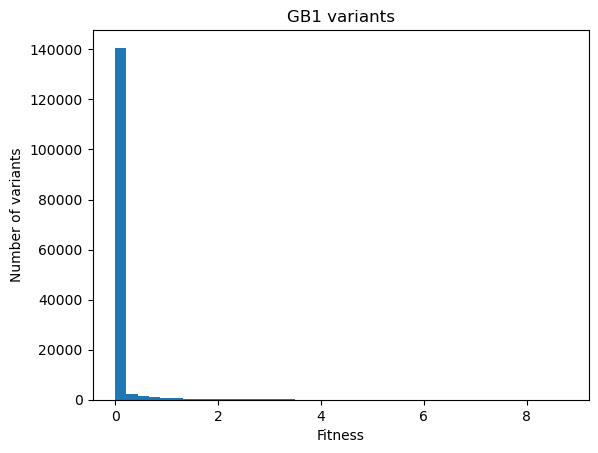

In [6]:
gb1_variants["DMS_score"].describe()

plt.hist(gb1_variants["DMS_score"], bins=40)
plt.ylabel("Number of variants")
plt.xlabel("Fitness")
plt.title("GB1 variants")
plt.show()

In [11]:
aln_path = "/Users/sebs_mac/uni_OneDrive/honours/data/gb1/alns/"
gb1_e = pd.read_pickle(aln_path + "gb1_extants_no_dupes.pkl")
gb1_a = pd.read_pickle(aln_path + "gb1_ancestors_no_dupes.pkl")

gb1_extant_seqs = [x for x in gb1_e["sequence"]]
gb1_ancestor_seqs = [x for x in gb1_a["sequence"]]

data = [gb1_extant_seqs, gb1_ancestor_seqs]
labels = ["GB1 extant MSA", "GB1 ancestor MSA"]

In [25]:
#convert to numpy form for quick processing
gb1_e_col_entropy = stats.calc_shannon_entropy(gb1_e) 
gb1_a_col_entropy = stats.calc_shannon_entropy(gb1_a)

Sequence weight numpy array created with shape (num_seqs, columns):  (2286, 448)
Sequence weight numpy array created with shape (num_seqs, columns):  (12733, 448)


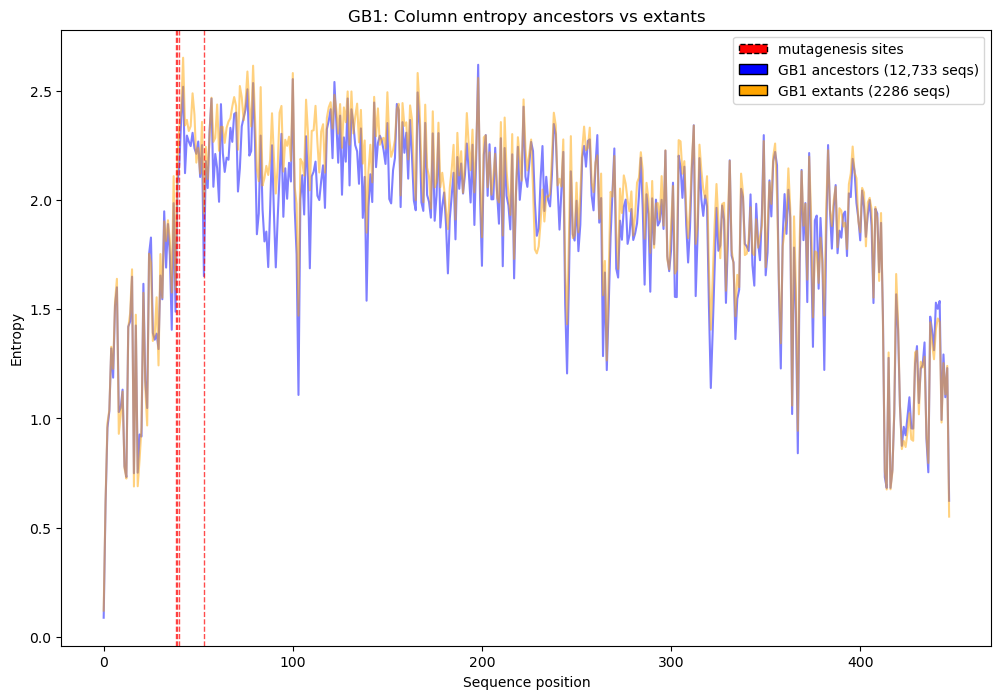

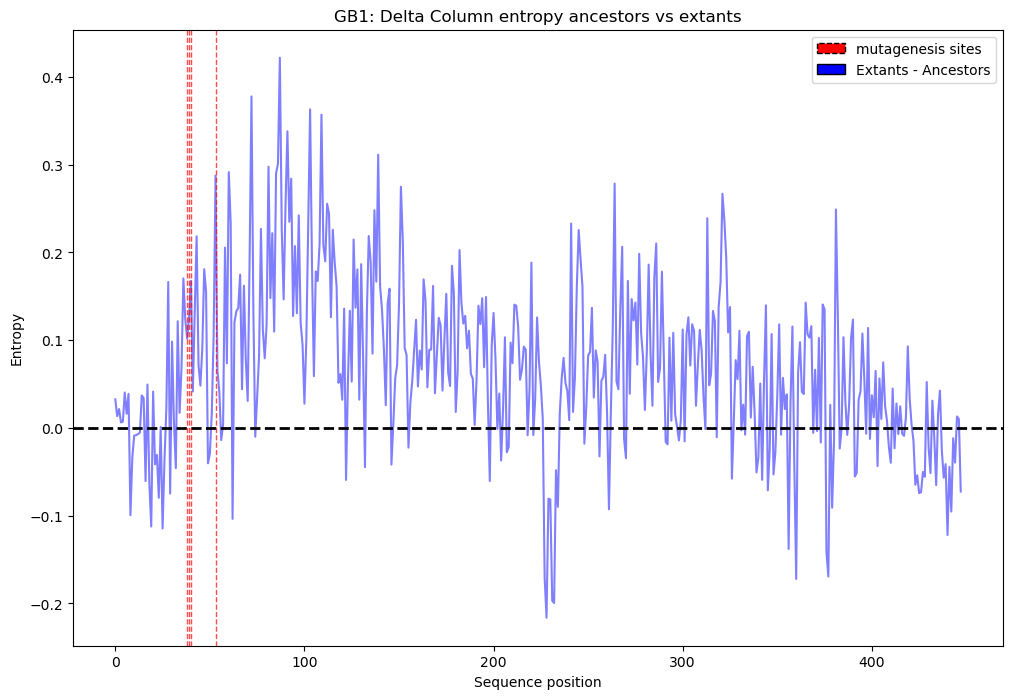

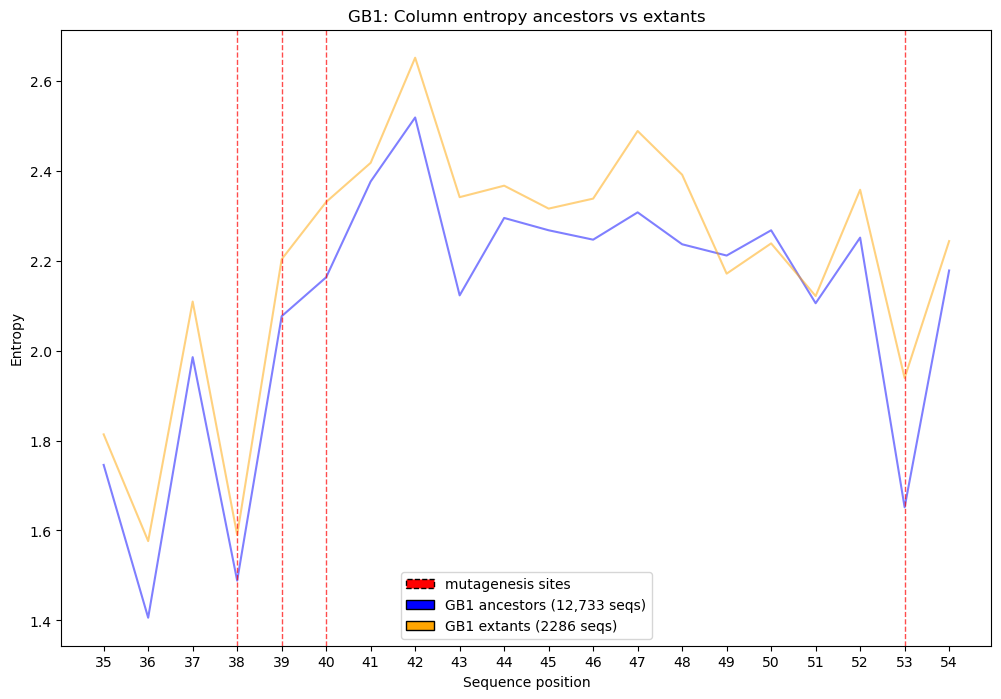

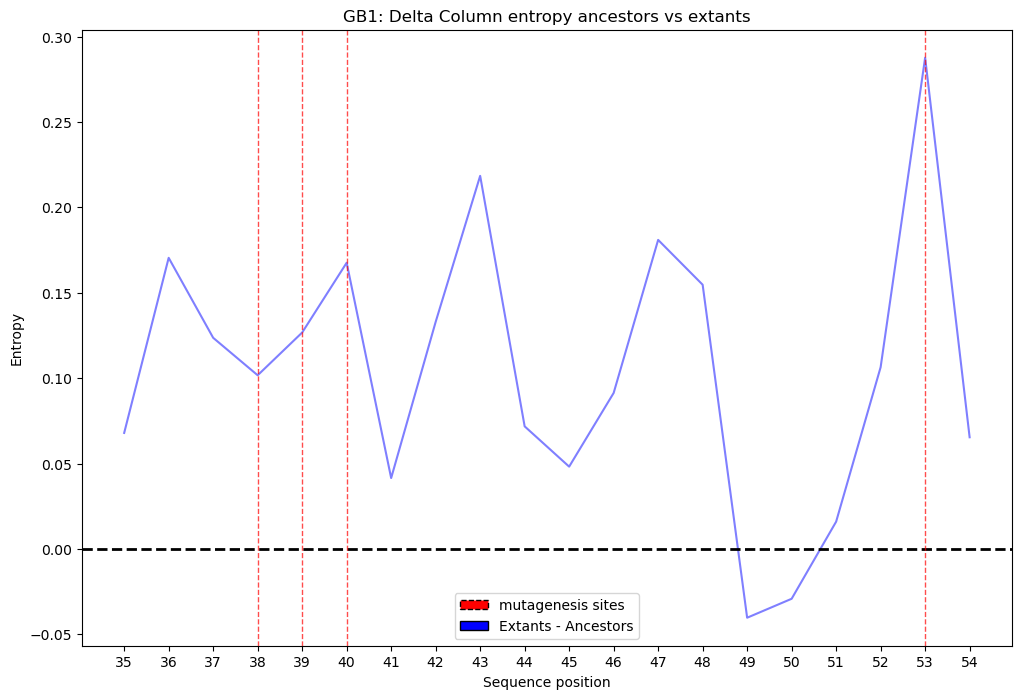

In [121]:

# across entire sequnece 
xticks = range(0, len(gb1_e_col_entropy))

fig = plt.figure(figsize=(12, 8))
plt.plot(xticks, gb1_a_col_entropy, alpha=0.5,  color='blue')
plt.plot(xticks, gb1_e_col_entropy, alpha=0.5, color='orange')
plt.xlabel("Sequence position")
plt.ylabel("Entropy")

legend_elements = [
    Patch(facecolor='r', edgecolor='black',linestyle='--', label='mutagenesis sites'),
    Patch(facecolor='blue', edgecolor='black',label="GB1 ancestors (12,733 seqs)"),
    Patch(facecolor='orange', edgecolor='black', label="GB1 extants (2286 seqs)"),
]

plt.legend(handles=legend_elements,)

mutations = [38, 39, 40, 53]
for mutation in mutations:
    plt.axvline(x=mutation, color='r', linestyle='--', linewidth=1, alpha=0.7)

plt.title("GB1: Column entropy ancestors vs extants")
plt.show()

# Delta elbo across entire sequnece 
xticks = range(0, len(gb1_e_col_entropy))
delta_col_h = gb1_e_col_entropy - gb1_a_col_entropy

fig = plt.figure(figsize=(12, 8))
plt.plot(xticks, delta_col_h, alpha=0.5, label="GB1 ancestors (12,733 seqs)", color='blue')
plt.xlabel("Sequence position")
plt.ylabel("Entropy")

plt.axhline(y=0, color='black', linestyle='--', linewidth=2)


legend_elements = [
    Patch(facecolor='r', edgecolor='black',linestyle='--', label='mutagenesis sites'),
    Patch(facecolor='blue', edgecolor='black', label='Extants - Ancestors'),
]

plt.legend(handles=legend_elements,)

mutations = [38, 39, 40, 53]
for mutation in mutations:
    plt.axvline(x=mutation, color='r', linestyle='--', linewidth=1, alpha=0.7)

plt.title("GB1: Delta Column entropy ancestors vs extants")
plt.show()


# now just across the mutation sites 
xticks = range(35, 55)

fig = plt.figure(figsize=(12, 8))
plt.plot(xticks, gb1_a_col_entropy[35:55], alpha=0.5, label="GB1 ancestors (12,733 seqs)", color='blue')
plt.plot(xticks, gb1_e_col_entropy[35:55], alpha=0.5, label="GB1 extants (2286 seqs)", color='orange')
plt.xlabel("Sequence position")
plt.ylabel("Entropy")

legend_elements = [
    Patch(facecolor='r', edgecolor='black',linestyle='--', label='mutagenesis sites'),
    Patch(facecolor='blue', edgecolor='black',label="GB1 ancestors (12,733 seqs)"),
    Patch(facecolor='orange', edgecolor='black', label="GB1 extants (2286 seqs)"),
]


plt.xticks(ticks=xticks, labels=xticks)
plt.legend(handles=legend_elements,)

mutations = [38, 39, 40, 53]
for mutation in mutations:
    plt.axvline(x=mutation, color='r', linestyle='--', linewidth=1, alpha=0.7)

plt.title("GB1: Column entropy ancestors vs extants")
plt.show()

# Delta elbo across subset of sequnece 
xticks = range(35, 55)
delta_col_h = (gb1_e_col_entropy - gb1_a_col_entropy)[35:55]

fig = plt.figure(figsize=(12, 8))
plt.plot(xticks, delta_col_h, alpha=0.5, label="GB1 ancestors (12,733 seqs)", color='blue')
plt.xlabel("Sequence position")
plt.ylabel("Entropy")

plt.xticks(ticks=xticks, labels=xticks)
plt.axhline(y=0, color='black', linestyle='--', linewidth=2)


legend_elements = [
    Patch(facecolor='r', edgecolor='black',linestyle='--', label='mutagenesis sites'),
    Patch(facecolor='blue', edgecolor='black', label='Extants - Ancestors'),
]

plt.legend(handles=legend_elements,)

mutations = [38, 39, 40, 53]
for mutation in mutations:
    plt.axvline(x=mutation, color='r', linestyle='--', linewidth=1, alpha=0.7)

plt.title("GB1: Delta Column entropy ancestors vs extants")
plt.show()



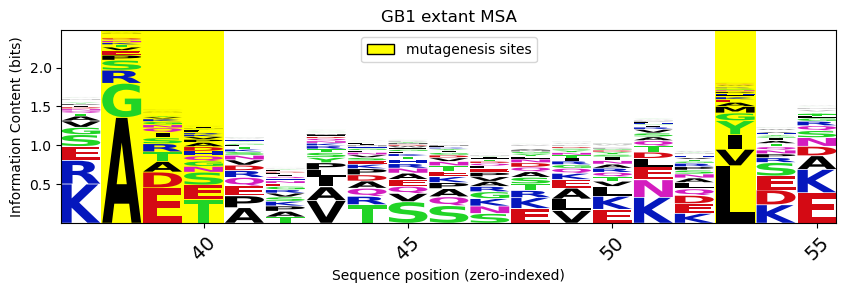

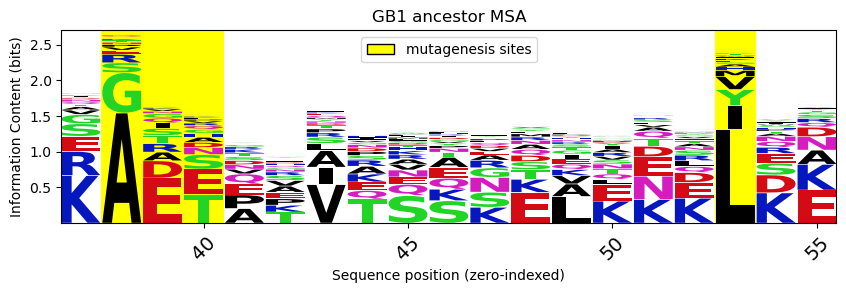

In [12]:


for d, l in zip(data, labels):

    counts_mat = lm.alignment_to_matrix(d)
    counts_mat = counts_mat.iloc[37:56]


    info_mat = lm.transform_matrix(counts_mat, 
                                        from_type='counts', 
                                        to_type='information')
    
    logo = lm.Logo(info_mat,
                stack_order='small_on_top',
                vsep=0.01
                )

    logo.highlight_position_range(38,40,alpha=1, color='yellow')
    logo.highlight_position(53,color='yellow',alpha=1)
    logo.style_xticks(spacing=5, anchor=25, rotation=45, fmt='%d', fontsize=14)
    logo.ax.set_ylabel("Information Content (bits)")
    logo.ax.set_xlabel("Sequence position (zero-indexed)")
    logo.ax.set_title(l)

    legend_elements = [
        Patch(facecolor='yellow', edgecolor='black', label='mutagenesis sites'),
    ]

    # Step 3: Add the legend to the plot
    plt.legend(handles=legend_elements, loc='upper center')
    plt.show()




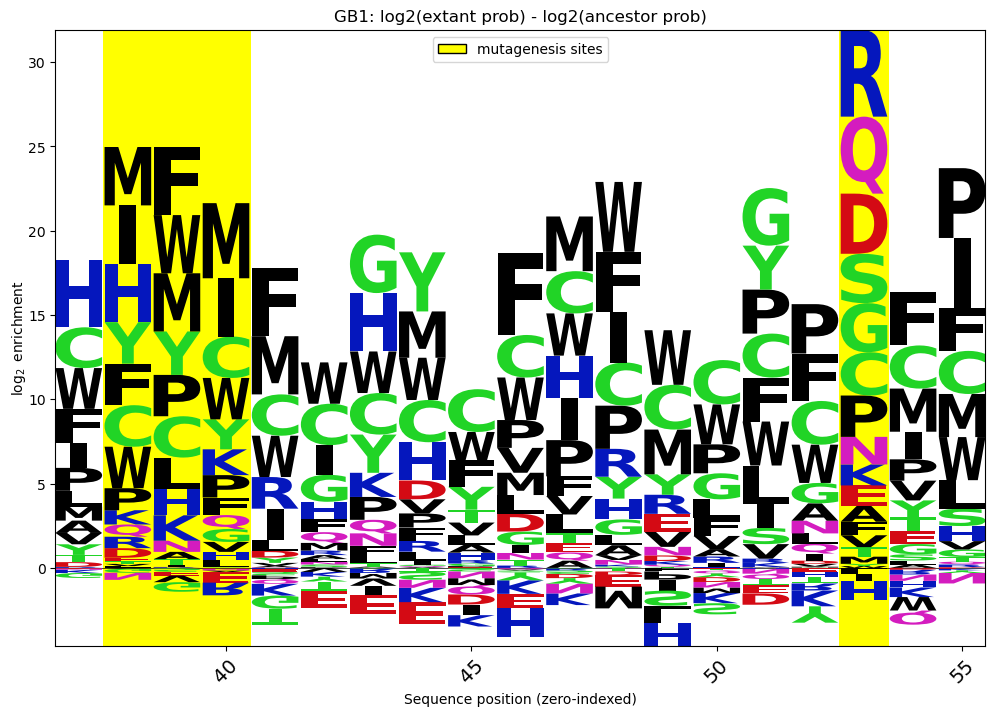

In [14]:
EXTANT = 0 
ANC = 1

mats = []
for d, l in zip(data, labels):

    counts_mat = lm.alignment_to_matrix(d)
    counts_mat = counts_mat.iloc[37:56]

    info_mat = lm.transform_matrix(counts_mat, 
                                        from_type='counts', 
                                        to_type='probability')
    
    mats.append(info_mat)
    
info_mat = np.log2(mats[EXTANT]) - np.log2(mats[ANC])
logo = lm.Logo(info_mat, figsize=(12,8))

logo.highlight_position_range(38,40,alpha=1, color='yellow')
logo.highlight_position(53,color='yellow',alpha=1)
logo.style_xticks(spacing=5, anchor=25, rotation=45, fmt='%d', fontsize=14)
logo.ax.set_ylabel("$\log_2$ enrichment")
logo.ax.set_xlabel("Sequence position (zero-indexed)")
logo.ax.set_title("GB1: log2(extant prob) - log2(ancestor prob)")
# style using Axes methods

logo.ax.set_ylabel('$\log_2$ enrichment', labelpad=0)

legend_elements = [
    Patch(facecolor='yellow', edgecolor='black', label='mutagenesis sites'),
]

# Step 3: Add the legend to the plot
plt.legend(handles=legend_elements, loc='upper center')

plt.show()

# GFP 

In [62]:
gfp_variants = pd.read_csv("/Users/sebs_mac/git_repos/dms_data/DMS_ProteinGym_substitutions/GFP_AEQVI_Sarkisyan_2016.csv")
gfp_variants.head()

,mutant,mutated_sequence,DMS_score,DMS_score_bin
0,K3R:V55A:Q94R:A110T:D117G:M153K:D216A,MSRGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,1.301030,0
1,K3Q:V16A:I167T:L195Q,MSQGEELFTGVVPILAELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,3.137350,1
2,K3Q:Y143C:N164D:S205P:A227T,MSQGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,1.553913,0
3,K3Q:Y143N:V193A,MSQGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,3.404237,1
4,K3R,MSRGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKF...,3.738586,1


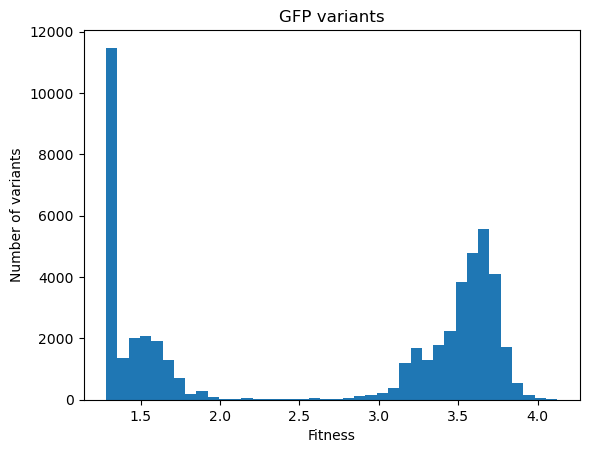

In [63]:
plt.hist(gfp_variants["DMS_score"], bins=40)
plt.ylabel("Number of variants")
plt.xlabel("Fitness")
plt.title("GFP variants")
plt.show()

In [66]:
aln_path = "/Users/sebs_mac/uni_OneDrive/honours/data/gfp_alns/independent_runs/no_synthetic/alns/"
gfp_e = pd.read_pickle(aln_path + "gfp_extants_no_syn_no_dupes.pkl")
gfp_a = pd.read_pickle(aln_path + "gfp_ancestors_no_syn_no_dupes.pkl")

gfp_extant_seqs = [x for x in gfp_e["sequence"]]
gfp_ancestor_seqs = [x for x in gfp_a["sequence"]]

data = [gfp_extant_seqs, gfp_ancestor_seqs]
labels = ["GFP extant MSA", "GFP ancestor MSA"]

In [67]:
#convert to numpy form for quick processing
gfp_e_col_entropy = stats.calc_shannon_entropy(gfp_e) 
gfp_a_col_entropy = stats.calc_shannon_entropy(gfp_a)

Sequence weight numpy array created with shape (num_seqs, columns):  (324, 238)
Sequence weight numpy array created with shape (num_seqs, columns):  (497, 238)


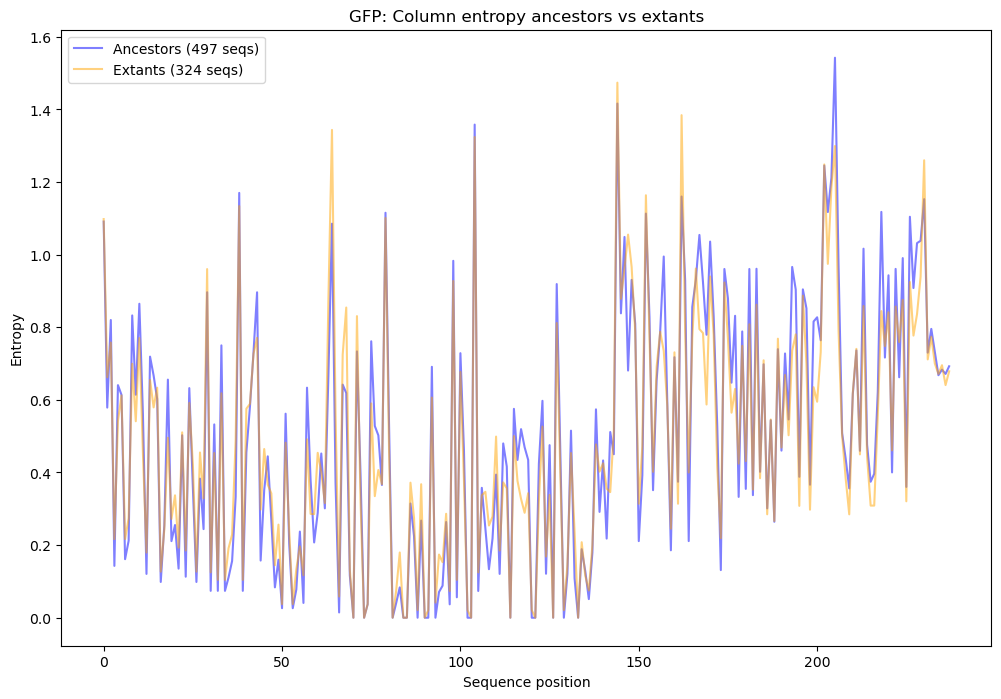

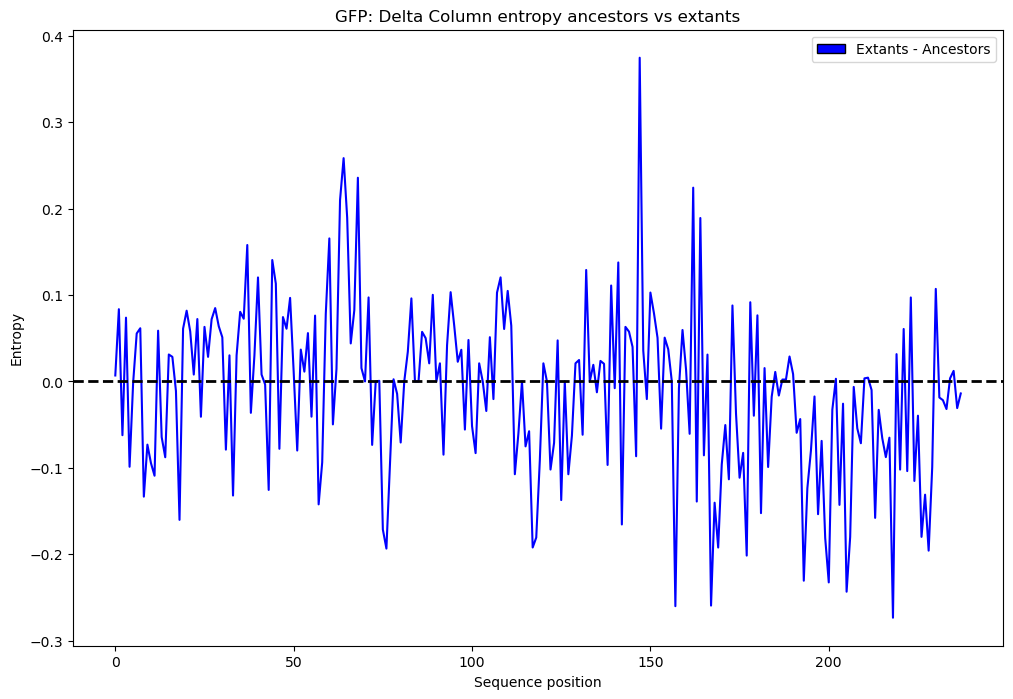

In [120]:

# across entire sequnece 
xticks = range(0, len(gfp_e_col_entropy))

fig = plt.figure(figsize=(12, 8))
plt.plot(xticks, gfp_a_col_entropy, alpha=0.5, label="Ancestors (497 seqs)", color='blue')
plt.plot(xticks, gfp_e_col_entropy, alpha=0.5, label="Extants (324 seqs)", color='orange')
plt.xlabel("Sequence position")
plt.ylabel("Entropy")


plt.legend()

plt.title("GFP: Column entropy ancestors vs extants")
plt.show()

# Delta elbo across entire sequnece 
xticks = range(0, len(gfp_e_col_entropy))
delta_col_h = gfp_e_col_entropy - gfp_a_col_entropy

fig = plt.figure(figsize=(12, 8))
plt.plot(xticks, delta_col_h, alpha=1, label="Delta entropy (Extants - Ancestors)", color='blue')
plt.xlabel("Sequence position")
plt.ylabel("Entropy")

plt.axhline(y=0, color='black', linestyle='--', linewidth=2)

legend_elements = [
    Patch(facecolor='blue', edgecolor='black', label='Extants - Ancestors'),
]

plt.legend(handles=legend_elements,)

plt.title("GFP: Delta Column entropy ancestors vs extants")
plt.show()





# A4 

In [76]:
#672-713 (673) /Users/sebs_mac/uni_OneDrive/honours/data/a4_human/alns A4_HUMAN_Seuma_2022

a4_variants = pd.read_csv("/Users/sebs_mac/git_repos/dms_data/DMS_ProteinGym_substitutions/A4_HUMAN_Seuma_2022.csv")
a4_variants.head()

,mutant,mutated_sequence,DMS_score,DMS_score_bin
0,A673C,MLPGLALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMN...,-1.018869,1
1,A673D,MLPGLALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMN...,-0.605052,1
2,A673E,MLPGLALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMN...,-0.590857,1
3,A673E:A692E,MLPGLALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMN...,-2.443601,0
4,A673E:A692T,MLPGLALLLLAAWTARALEVPTDGNAGLLAEPQIAMFCGRLNMHMN...,-3.049893,0


In [99]:
# all the mutation positoins will be here 
a4_muts = set()

for x in a4_variants["mutant"]:
    data = x.split(":")
    a = data[0][1:-1]
    a4_muts.add(a)
    if len(data) == 2:
        b = data[1][1:-1]
        a4_muts.add(b)
len(a4_muts)
print(min(a4_muts), max(a4_muts))

672 713


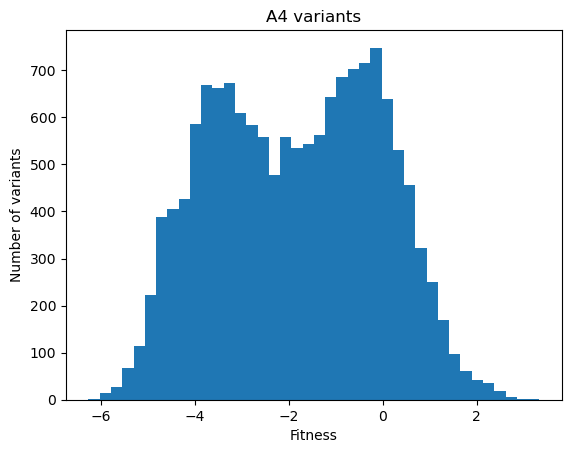

In [78]:
a4_variants["DMS_score"].describe()

plt.hist(a4_variants["DMS_score"], bins=40)
plt.ylabel("Number of variants")
plt.xlabel("Fitness")
plt.title("A4 variants")
plt.show()

In [79]:
aln_path = "/Users/sebs_mac/uni_OneDrive/honours/data/a4_human/alns/"
a4_e = pd.read_pickle(aln_path + "a4_extants_no_dupes.pkl")
a4_a = pd.read_pickle(aln_path + "a4_ancestors_no_dupes.pkl")

a4_extant_seqs = [x for x in a4_e["sequence"]]
a4_ancestor_seqs = [x for x in a4_a["sequence"]]

data = [gb1_extant_seqs, gb1_ancestor_seqs]
labels = ["A4 extant MSA", "A4 ancestor MSA"]

In [80]:
#convert to numpy form for quick processing
a4_e_col_entropy = stats.calc_shannon_entropy(a4_e) 
a4_a_col_entropy = stats.calc_shannon_entropy(a4_a)

Sequence weight numpy array created with shape (num_seqs, columns):  (4936, 770)
Sequence weight numpy array created with shape (num_seqs, columns):  (29940, 770)


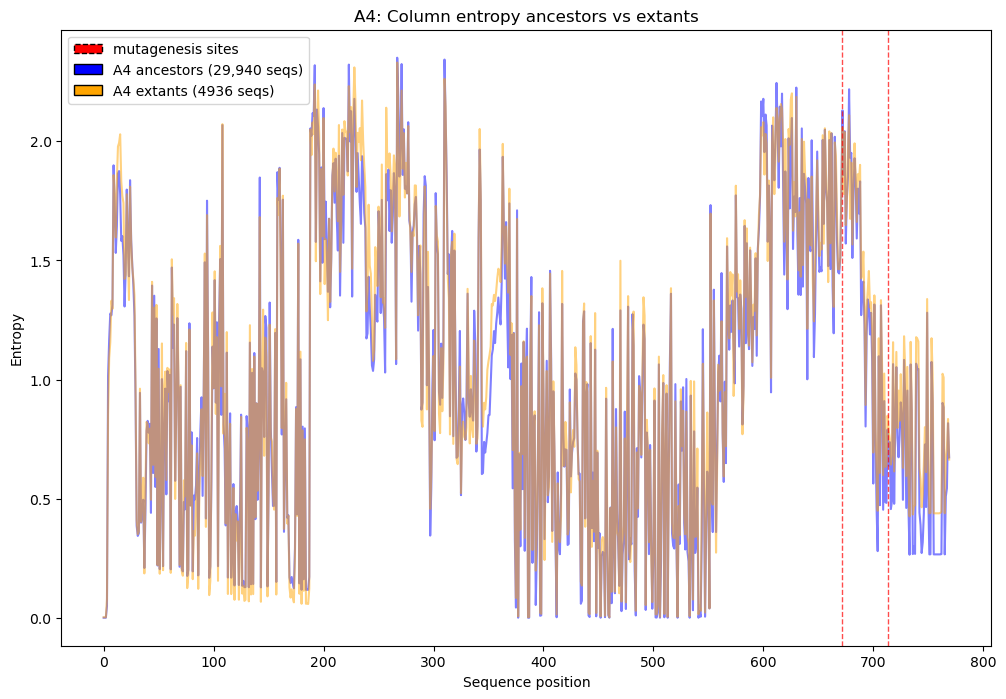

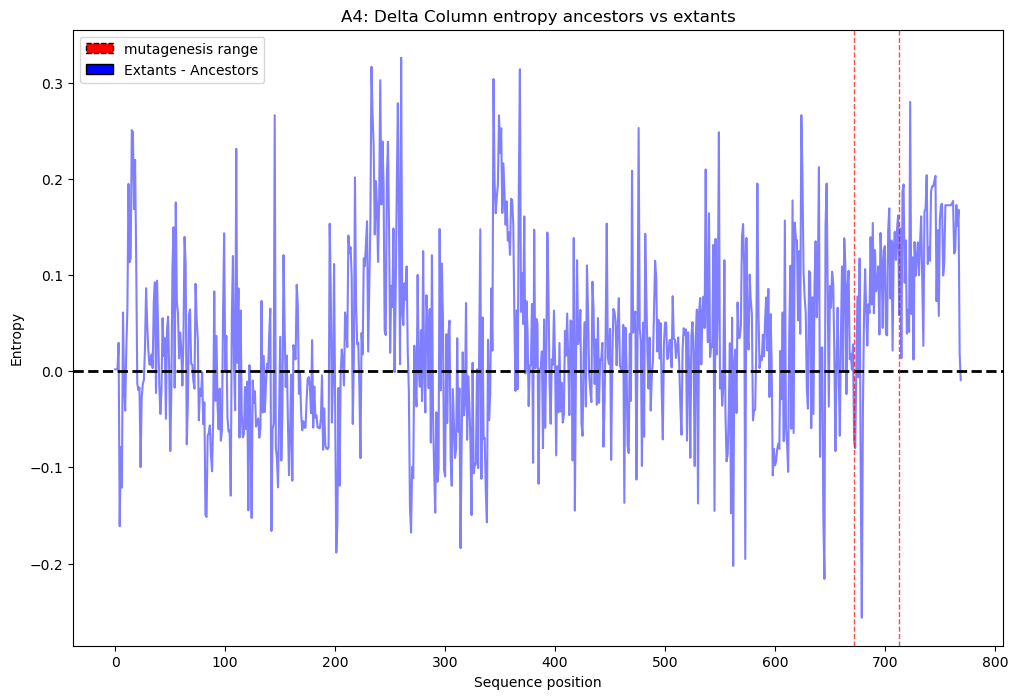

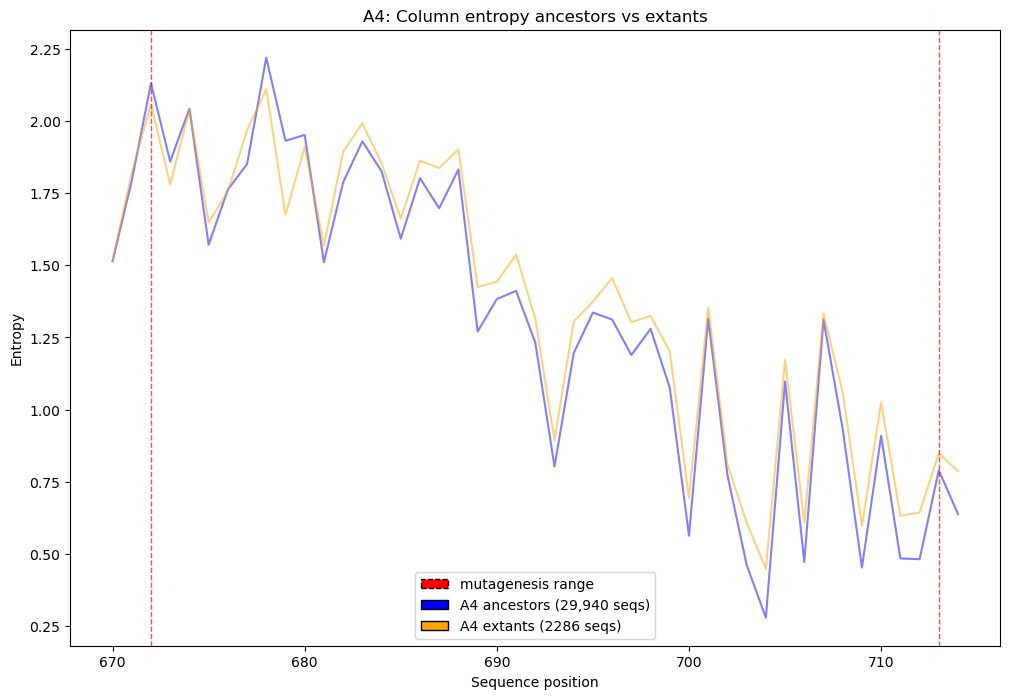

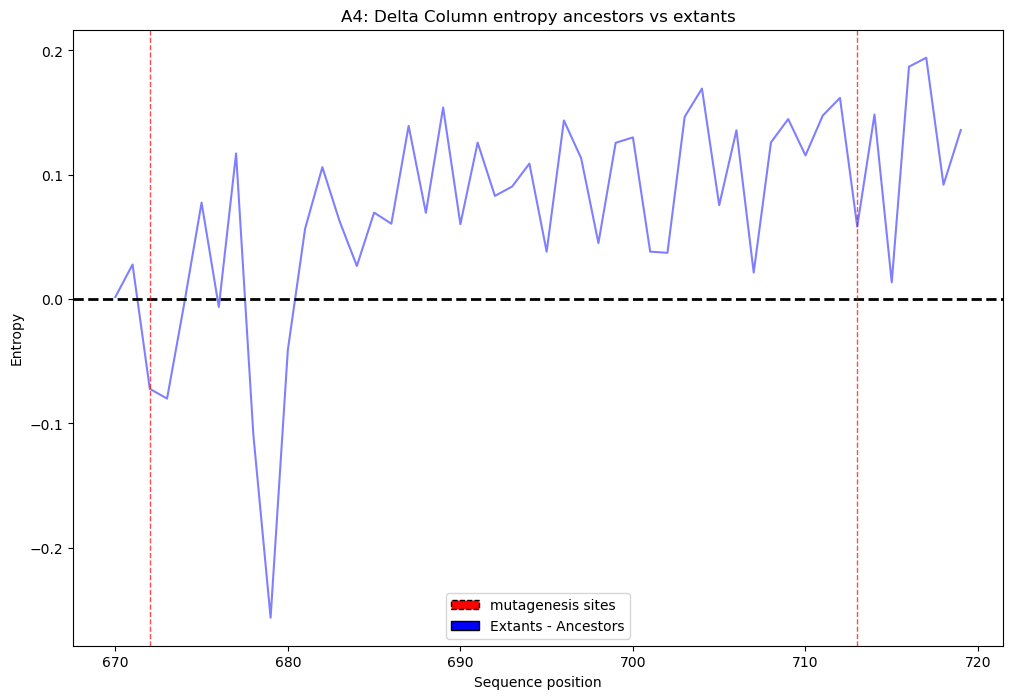

In [119]:

# across entire sequnece 
xticks = range(0, len(a4_e_col_entropy))

fig = plt.figure(figsize=(12, 8))
plt.plot(xticks, a4_a_col_entropy, alpha=0.5, label="A4 ancestors (29,940 seqs)", color='blue')
plt.plot(xticks, a4_e_col_entropy, alpha=0.5, label="A4 extants (4936 seqs)", color='orange')
plt.xlabel("Sequence position")
plt.ylabel("Entropy")

legend_elements = [
    Patch(facecolor='r', edgecolor='black',linestyle='--', label='mutagenesis sites'),
    Patch(facecolor='blue', edgecolor='black', label='A4 ancestors (29,940 seqs)'),
    Patch(facecolor='orange', edgecolor='black', label='A4 extants (4936 seqs)'),
]

plt.legend(handles=legend_elements,)

mutations = [672, 713]
for mutation in mutations:
    plt.axvline(x=mutation, color='r', linestyle='--', linewidth=1, alpha=0.7)

plt.title("A4: Column entropy ancestors vs extants")
plt.show()

########################################################################################################################
# Delta elbo across entire sequnece 
xticks = range(0, len(a4_e_col_entropy))
delta_col_h = a4_e_col_entropy - a4_a_col_entropy

fig = plt.figure(figsize=(12, 8))
plt.plot(xticks, delta_col_h, alpha=0.5, color='blue')
plt.xlabel("Sequence position")
plt.ylabel("Entropy")

plt.axhline(y=0, color='black', linestyle='--', linewidth=2)

legend_elements = [
    Patch(facecolor='r', edgecolor='black',linestyle='--', label='mutagenesis range'),
    Patch(facecolor='blue', edgecolor='black', label='Extants - Ancestors'),
]

plt.legend(handles=legend_elements,)

mutations = [672, 713]
for mutation in mutations:
    plt.axvline(x=mutation, color='r', linestyle='--', linewidth=1, alpha=0.7)

plt.title("A4: Delta Column entropy ancestors vs extants")
plt.show()

########################################################################################################################
# now just across the mutation sites 
xticks = range(670, 715)

fig = plt.figure(figsize=(12, 8))
plt.plot(xticks, a4_a_col_entropy[670:715], alpha=0.5, label="A4 ancestors (12,733 seqs)", color='blue')
plt.plot(xticks, a4_e_col_entropy[670:715], alpha=0.5, label="A4 extants (2286 seqs)", color='orange')
plt.xlabel("Sequence position")
plt.ylabel("Entropy")



legend_elements = [
    Patch(facecolor='r', edgecolor='black',linestyle='--', label='mutagenesis range'),
    Patch(facecolor='blue', edgecolor='black', label='A4 ancestors (29,940 seqs)'),
    Patch(facecolor='orange', edgecolor='black', label='A4 extants (2286 seqs)'),
]


#plt.xticks(ticks=xticks, labels=xticks)
plt.legend(handles=legend_elements,)

mutations = [672, 713]
for mutation in mutations:
    plt.axvline(x=mutation, color='r', linestyle='--', linewidth=1, alpha=0.7)

plt.title("A4: Column entropy ancestors vs extants")
plt.show()

########################################################################################################################
# Delta elbo across subset of sequnece 
xticks = range(670, 720)
delta_col_h = (a4_e_col_entropy - a4_a_col_entropy)[670:720]

fig = plt.figure(figsize=(12, 8))
plt.plot(xticks, delta_col_h, alpha=0.5, label="A4 ancestors (12,733 seqs)", color='blue')
plt.xlabel("Sequence position")
plt.ylabel("Entropy")

#plt.xticks(ticks=xticks, labels=xticks)
plt.axhline(y=0, color='black', linestyle='--', linewidth=2)

legend_elements = [
    Patch(facecolor='r', edgecolor='black',linestyle='--', label='mutagenesis sites'),
    Patch(facecolor='blue', edgecolor='black', label='Extants - Ancestors'),

]

plt.legend(handles=legend_elements,)

mutations = [672, 713]
for mutation in mutations:
    plt.axvline(x=mutation, color='r', linestyle='--', linewidth=1, alpha=0.7)

plt.title("A4: Delta Column entropy ancestors vs extants")
plt.show()



# GCN4 

In [122]:
gcn4_variants = pd.read_csv("/Users/sebs_mac/git_repos/dms_data/DMS_ProteinGym_substitutions/GCN4_YEAST_Staller_2018.csv")
gcn4_variants.head()

,mutant,mutated_sequence,DMS_score,DMS_score_bin
0,D103A,MSEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFD...,1.543932,1
1,D103A:F108N:K118D:S122Q:V135I:D139W,MSEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFD...,1.158042,0
2,D103A:S104T:T105I:P106T:M107L:F108T:E109S:N112...,MSEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFD...,1.391235,1
3,D103A:S122A:V130Q:T132M:S144N,MSEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFD...,1.243840,0
4,D103A:S122E:S136P:K140S:A141R,MSEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFD...,1.678492,1


In [125]:
# all the mutation positoins will be here 
gcn4_muts = set()

for x in gcn4_variants["mutant"]:
    data = x.split(":")
    for z in data:
        b = z[1:-1]
        gcn4_muts.add(b)
print(len(gcn4_muts))
print(min(gcn4_muts), max(gcn4_muts))

44
101 144


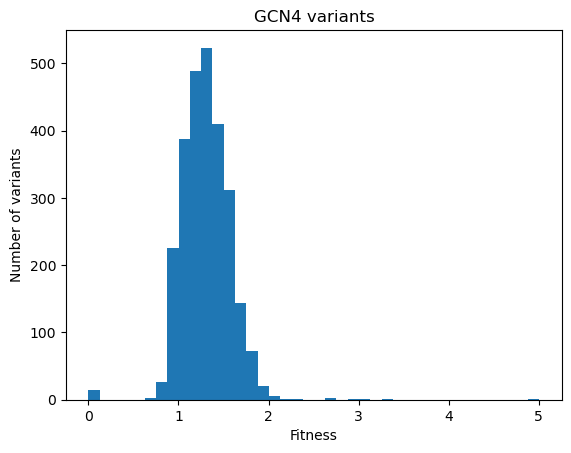

In [128]:
gcn4_variants["DMS_score"].describe()

plt.hist(gcn4_variants["DMS_score"], bins=40)
plt.ylabel("Number of variants")
plt.xlabel("Fitness")
plt.title("GCN4 variants")
plt.show()

In [129]:
aln_path = "/Users/sebs_mac/uni_OneDrive/honours/data/gcn4/alns/"
gcn4_e = pd.read_pickle(aln_path + "gcn4_extants_no_dupes.pkl")
gcn4_a = pd.read_pickle(aln_path + "gcn4_ancestors_no_dupes.pkl")

a4_extant_seqs = [x for x in gcn4_e["sequence"]]
a4_ancestor_seqs = [x for x in gcn4_a["sequence"]]

data = [gb1_extant_seqs, gb1_ancestor_seqs]
labels = ["GCN4 extant MSA", "GCN4 ancestor MSA"]

In [130]:
#convert to numpy form for quick processing
gcn4_e_col_entropy = stats.calc_shannon_entropy(gcn4_e) 
gcn4_a_col_entropy = stats.calc_shannon_entropy(gcn4_a)

Sequence weight numpy array created with shape (num_seqs, columns):  (331, 281)
Sequence weight numpy array created with shape (num_seqs, columns):  (11623, 281)


In [ ]:

# across entire sequnece 
xticks = range(0, len(gcn4_e_col_entropy))

fig = plt.figure(figsize=(12, 8))
plt.plot(xticks, gcn4_a_col_entropy, alpha=0.5, color='blue')
plt.plot(xticks, gcn4_e_col_entropy, alpha=0.5, color='orange')
plt.xlabel("Sequence position")
plt.ylabel("Entropy")

legend_elements = [
    Patch(facecolor='r', edgecolor='black',linestyle='--', label='mutagenesis sites'),
    Patch(facecolor='blue', edgecolor='black', label='A4 ancestors (29,940 seqs)'),
    Patch(facecolor='orange', edgecolor='black', label='A4 extants (4936 seqs)'),
]

plt.legend(handles=legend_elements,)

mutations = [672, 713]
for mutation in mutations:
    plt.axvline(x=mutation, color='r', linestyle='--', linewidth=1, alpha=0.7)

plt.title("A4: Column entropy ancestors vs extants")
plt.show()

########################################################################################################################
# Delta elbo across entire sequnece 
xticks = range(0, len(a4_e_col_entropy))
delta_col_h = a4_e_col_entropy - a4_a_col_entropy

fig = plt.figure(figsize=(12, 8))
plt.plot(xticks, delta_col_h, alpha=0.5, color='blue')
plt.xlabel("Sequence position")
plt.ylabel("Entropy")

plt.axhline(y=0, color='black', linestyle='--', linewidth=2)

legend_elements = [
    Patch(facecolor='r', edgecolor='black',linestyle='--', label='mutagenesis range'),
    Patch(facecolor='blue', edgecolor='black', label='Extants - Ancestors'),
]

plt.legend(handles=legend_elements,)

mutations = [672, 713]
for mutation in mutations:
    plt.axvline(x=mutation, color='r', linestyle='--', linewidth=1, alpha=0.7)

plt.title("A4: Delta Column entropy ancestors vs extants")
plt.show()

########################################################################################################################
# now just across the mutation sites 
xticks = range(670, 715)

fig = plt.figure(figsize=(12, 8))
plt.plot(xticks, a4_a_col_entropy[670:715], alpha=0.5, label="A4 ancestors (12,733 seqs)", color='blue')
plt.plot(xticks, a4_e_col_entropy[670:715], alpha=0.5, label="A4 extants (2286 seqs)", color='orange')
plt.xlabel("Sequence position")
plt.ylabel("Entropy")



legend_elements = [
    Patch(facecolor='r', edgecolor='black',linestyle='--', label='mutagenesis range'),
    Patch(facecolor='blue', edgecolor='black', label='A4 ancestors (29,940 seqs)'),
    Patch(facecolor='orange', edgecolor='black', label='A4 extants (2286 seqs)'),
]


#plt.xticks(ticks=xticks, labels=xticks)
plt.legend(handles=legend_elements,)

mutations = [672, 713]
for mutation in mutations:
    plt.axvline(x=mutation, color='r', linestyle='--', linewidth=1, alpha=0.7)

plt.title("A4: Column entropy ancestors vs extants")
plt.show()

########################################################################################################################
# Delta elbo across subset of sequnece 
xticks = range(670, 720)
delta_col_h = (a4_e_col_entropy - a4_a_col_entropy)[670:720]

fig = plt.figure(figsize=(12, 8))
plt.plot(xticks, delta_col_h, alpha=0.5, label="A4 ancestors (12,733 seqs)", color='blue')
plt.xlabel("Sequence position")
plt.ylabel("Entropy")

#plt.xticks(ticks=xticks, labels=xticks)
plt.axhline(y=0, color='black', linestyle='--', linewidth=2)

legend_elements = [
    Patch(facecolor='r', edgecolor='black',linestyle='--', label='mutagenesis sites'),
    Patch(facecolor='blue', edgecolor='black', label='Extants - Ancestors'),

]

plt.legend(handles=legend_elements,)

mutations = [672, 713]
for mutation in mutations:
    plt.axvline(x=mutation, color='r', linestyle='--', linewidth=1, alpha=0.7)

plt.title("A4: Delta Column entropy ancestors vs extants")
plt.show()

